# Project: Web scrapping, knowledge base construction

Webdatamining project 


<span style="color:red">Natalia GERARD and Paul RANC</span>

## Part 1: Web scrapping and knowledge base construction

Environment Setup   
Installation of required Python libraries

In [1]:
!pip install datasets sklearn-crfsuite transformers beautifulsoup4 nltk spacy rdflib

Dataset Loading  
Loading the CoNLL-2003 dataset using Hugging Face

In [2]:
from datasets import load_dataset

# Access train/validation/test splits
dataset = load_dataset("conll2003")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

Found cached dataset conll2003 (C:/Users/ngera/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

First training sample  
Check the structure of the data

In [3]:
print(train_dataset[0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


*Meaning of ner_tags to better understand the output*

### 🧾 NER Tag Codebook

| Code | Label     | Meaning                          |
|------|-----------|----------------------------------|
| 0    | O         | Not a named entity               |
| 1    | B-PER     | Beginning of a PERSON            |
| 2    | I-PER     | Inside a PERSON name             |
| 3    | B-ORG     | Beginning of an ORGANIZATION     |
| 4    | I-ORG     | Inside an ORGANIZATION name      |
| 5    | B-LOC     | Beginning of a LOCATION          |
| 6    | I-LOC     | Inside a LOCATION                |
| 7    | B-MISC    | Beginning of a miscellaneous entity |
| 8    | I-MISC    | Inside a miscellaneous entity    |

So in this example : 

“EU” is an organization → B-ORG = 3  

“German” and ‘British’ are various entities (nationalities here) → B-MISC = 7   

Other words are not entities → 0

Visualize the frequency of NER entities in the training set

In [4]:
from collections import Counter

# Count NER tags in the training dataset
ner_counts = Counter(tag for example in train_dataset for tag in example['ner_tags'])
print("NER tag distribution:", ner_counts)


NER tag distribution: Counter({0: 169578, 5: 7140, 1: 6600, 3: 6321, 2: 4528, 4: 3704, 7: 3438, 6: 1157, 8: 1155})


The NER tag distribution in the training set shows that the majority of tokens (169,578) are not named entities (tag 0). Among the named entities, the most frequent are LOC (B-LOC: 7,140), PER (B-PER: 6,600, I-PER: 4,528), ORG (B-ORG: 6,321, I-ORG: 3,704), and MISC (B-MISC: 3,438, I-MISC: 1,155), indicating a good variety of entity types

### Task 1 : Model for NER

**Text Cleaning & Preprocessing : clean and prepare text for CRF model training**

Remove punctuation and non-text elements (except hyphens)

In [5]:
import re

def remove_punctuation(text):
    """
    Remove all punctuation and non-text elements, except hyphens.
    Hyphens are kept because they are used in compound words.
    """
    # Only keep word characters, whitespace, and hyphens
    return re.sub(r"[^\w\s-]", "", text)

In [6]:
# Example
raw_text = "Apple, Inc. was founded in 1976 - by Steve Jobs!"
cleaned_text = remove_punctuation(raw_text)
print("Cleaned text:", cleaned_text)

Cleaned text: Apple Inc was founded in 1976 - by Steve Jobs


Normalize the text by converting to lowercase.

In [7]:
import nltk
from nltk import word_tokenize

# Download necessary data once
nltk.download('punkt')

def normalize_and_tokenize(text):
    """
    Convert to lowercase and tokenize the text into words.
    """
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Example
normalized_tokens = normalize_and_tokenize(cleaned_text)
print("Normalized & Tokenized:", normalized_tokens)

Normalized & Tokenized: ['apple', 'inc', 'was', 'founded', 'in', '1976', '-', 'by', 'steve', 'jobs']


Removing stop words, and applying tokenization and stemming/lemmatization.

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download additional NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(tokens):
    """
    Remove English stopwords and apply lemmatization.
    """
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Final preprocessing
final_tokens = remove_stopwords_and_lemmatize(normalized_tokens)
print("Final preprocessed tokens:", final_tokens)

Final preprocessed tokens: ['apple', 'inc', 'founded', '1976', '-', 'steve', 'job']


This step is crucial to prepare the raw text for Named Entity Recognition (NER) by simplifying it, removing irrelevant elements (like punctuation and stopwords), and standardizing word forms. This helps improve the accuracy and efficiency of the CRF model we'll train next.

**Named Entity Recognition (NER):**

The CoNLL-2003 dataset is already pre-processed:  

Tokens are already separated ('tokens' column).  

Punctuation has been largely cleaned up.  

Each word is aligned with its NER tag. 

Goal : Train a CRF (Conditional Random Field) model from the CoNLL-2003 dataset to automatically recognize named entities (people, places, organizations, etc.).

<span style="color:green">Train a Conditional Random Field (CRF) model to identify named entities such as PERSON,
ORGANIZATION, LOCATION, etc. You can use libraries like sklearn-crfsuite for this task.
</span>

First Approach : detect entities from scratch, as if we were training our own NER model from an annotated dataset.

In [11]:
from datasets import load_dataset
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Load dataset
dataset = load_dataset("conll2003")
train_data = dataset['train']
test_data = dataset['test']

# Get label names
label_list = dataset['train'].features['ner_tags'].feature.names

# Feature extraction
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i - 1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True
    if i < len(sent) - 1:
        word1 = sent[i + 1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True
    return features

# Transform sentence to list of features
def sent2features(example):
    return [word2features(example['tokens'], i) for i in range(len(example['tokens']))]

# Labels (convert IDs to string names)
def sent2labels(example):
    return [label_list[i] for i in example['ner_tags']]

# Prepare data
X_train = [sent2features(ex) for ex in train_data]
y_train = [sent2labels(ex) for ex in train_data]
X_test = [sent2features(ex) for ex in test_data]
y_test = [sent2labels(ex) for ex in test_data]

# Train CRF
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
crf.fit(X_train, y_train)

# Evaluate
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred))


Found cached dataset conll2003 (C:/Users/ngera/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B-LOC       0.86      0.81      0.84      1668
      B-MISC       0.82      0.74      0.77       702
       B-ORG       0.82      0.69      0.75      1661
       B-PER       0.82      0.85      0.83      1617
       I-LOC       0.81      0.73      0.77       257
      I-MISC       0.68      0.66      0.67       216
       I-ORG       0.70      0.74      0.72       835
       I-PER       0.84      0.95      0.89      1156
           O       0.98      0.99      0.99     38323

    accuracy                           0.95     46435
   macro avg       0.82      0.79      0.80     46435
weighted avg       0.95      0.95      0.95     46435



<span style="color:green">Use spaCyʼs en_ner_conll03 pre-trained NER model to identify named entities. This model
is also trained on ConLL2003 dataset. The code for training process is available here.
</span>

Second Approach : Use a model already trained by spaCy (en_ner_conll03) to automatically detect entities in plain text.

It shows how to reuse a ready-to-use template without training, and get immediate results on free text.

In [12]:
import spacy

# Load the pre-trained model 
nlp = spacy.load("C:\\Users\\ngera\\Downloads\\en_ner_conll03 (1)\\best_ner_model")

# Example text
text = "Apple was founded by Steve Jobs in California."
doc = nlp(text)

# Extract recognized entities
entities = [(ent.text, ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]
print("Named Entities (spaCy):", entities)

C:\Users\ngera\anaconda33\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Named Entities (spaCy): [('Apple', 'ORG', 0, 5), ('Steve Jobs', 'PER', 21, 31), ('California', 'LOC', 35, 45)]


<span style="color:green">Compare the performance of the CRF model with the spaCy pre-trained model. The
performances should be compared by accuracy, precision and F1 measure.
</span>

Evaluate CRF Model – Entity Extraction

In [13]:
def extract_crf_entities(tokens, labels):
    """
    Convert token-level IOB labels into entity spans with text and character positions.
    """
    entities = []
    current_entity = None
    start = None

    for i, (token, label) in enumerate(zip(tokens, labels)):
        if label.startswith("B-"):
            if current_entity:
                entities.append((current_entity, entity_type, start, end))
            current_entity = token
            entity_type = label[2:]
            start = len(" ".join(tokens[:i])) + (1 if i != 0 else 0)
            end = start + len(token)
        elif label.startswith("I-") and current_entity:
            current_entity += " " + token
            end += len(token) + 1  # account for space
        else:
            if current_entity:
                entities.append((current_entity, entity_type, start, end))
                current_entity = None

    if current_entity:
        entities.append((current_entity, entity_type, start, end))

    return entities

# Example
example = test_data[0]
tokens = example['tokens']
crf_labels = crf.predict_single(sent2features(example))
crf_entities = extract_crf_entities(tokens, crf_labels)
print("CRF Entities:", crf_entities)

CRF Entities: [('JAPAN', 'LOC', 9, 14), ('CHINA', 'LOC', 31, 36)]


Extract Entities from spaCy on the Same Sentence

In [14]:
import spacy

# Load the spaCy model
nlp = spacy.load("C:/Users/ngera/Downloads/en_ner_conll03 (1)/best_ner_model")

# Rebuild the sentence
text = " ".join(tokens)
doc = nlp(text)

# Get spaCy entities
spacy_entities = [(ent.text, ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]
print("spaCy Entities:", spacy_entities)

spaCy Entities: [('JAPAN', 'LOC', 9, 14), ('CHINA', 'LOC', 31, 36)]


<span style="color:blue">Named entity recognition</span>

Visual Comparison of Detected Entities

In [15]:
print("Text:", text)
print("\nCRF Entities:")
for ent in crf_entities:
    print(ent)

print("\nspaCy Entities:")
for ent in spacy_entities:
    print(ent)

Text: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .

CRF Entities:
('JAPAN', 'LOC', 9, 14)
('CHINA', 'LOC', 31, 36)

spaCy Entities:
('JAPAN', 'LOC', 9, 14)
('CHINA', 'LOC', 31, 36)


Performance Comparison on Full Test Set

Goal : Evaluate both models on the same dataset (CoNLL-2003 test) and compare their performance using precision, recall, and F1-score — for named entity recognition (NER).

To fairly compare both models, we evaluate them on the same test set from CoNLL-2003. The CRF model produces IOB tags directly, while the spaCy model requires converting predicted entities into IOB format.  

We use standard metrics (precision, recall, F1-score) from the `seqeval` library to assess their performance.  

This allows us to measure which model performs better at detecting PERSON, ORG, LOC, and MISC entities.

In [16]:
!pip install seqeval

In [17]:
y_pred_crf = y_pred  

In [18]:
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import spacy

# Load your spaCy model
nlp = spacy.load("C:/Users/ngera/Downloads/en_ner_conll03 (1)/best_ner_model")

# Convert spaCy outputs to IOB format
def spacy_predict_iob(tokens):
    text = " ".join(tokens)
    doc = nlp(text)
    iob_tags = ['O'] * len(tokens)
    ent_pos = {ent.start: (ent.label_, len(ent)) for ent in doc.ents}

    i = 0
    while i < len(tokens):
        if i in ent_pos:
            label, length = ent_pos[i]
            iob_tags[i] = 'B-' + label
            for j in range(1, length):
                if i + j < len(tokens):
                    iob_tags[i + j] = 'I-' + label
            i += length
        else:
            i += 1
    return iob_tags

# Apply to all test sentences
y_pred_spacy = [spacy_predict_iob(ex['tokens']) for ex in test_data]
y_true = [sent2labels(ex) for ex in test_data]

# Evaluate
print("spaCy Model Evaluation on CoNLL-2003 Test Set:")
print(classification_report(y_true, y_pred_spacy))

print("CRF Model Evaluation on CoNLL-2003 Test Set:")
print(classification_report(y_true, y_pred_crf))

# Summary scores
print("spaCy - Precision:", precision_score(y_true, y_pred_spacy))
print("spaCy - Recall:", recall_score(y_true, y_pred_spacy))
print("spaCy - F1:", f1_score(y_true, y_pred_spacy))

print("CRF - Precision:", precision_score(y_true, y_pred_crf))
print("CRF - Recall:", recall_score(y_true, y_pred_crf))
print("CRF - F1:", f1_score(y_true, y_pred_crf))

spaCy Model Evaluation on CoNLL-2003 Test Set:
              precision    recall  f1-score   support

         LOC       0.69      0.64      0.66      1668
        MISC       0.67      0.63      0.65       702
         ORG       0.70      0.67      0.68      1661
         PER       0.63      0.65      0.64      1617

   micro avg       0.67      0.65      0.66      5648
   macro avg       0.67      0.65      0.66      5648
weighted avg       0.67      0.65      0.66      5648

CRF Model Evaluation on CoNLL-2003 Test Set:
              precision    recall  f1-score   support

         LOC       0.86      0.81      0.83      1668
        MISC       0.80      0.72      0.76       702
         ORG       0.79      0.66      0.71      1661
         PER       0.81      0.84      0.83      1617

   micro avg       0.82      0.76      0.79      5648
   macro avg       0.81      0.76      0.78      5648
weighted avg       0.82      0.76      0.79      5648

spaCy - Precision: 0.6705107084019769


Based on the evaluation on the CoNLL-2003 test set, the CRF model outperforms the spaCy pre-trained model in all metrics. The CRF model achieves a higher precision (81.6% vs. 67.0%), recall (76.2% vs. 64.9%), and F1-score (78.8% vs. 65.9%). This indicates that, although spaCy provides a convenient out-of-the-box solution, a well-trained CRF on the same dataset can deliver significantly better performance for Named Entity Recognition.

<span style="color:green">Save the extracted entities along with their positions.
</span>

Save Extracted Named Entities from spaCy with Positions

In [19]:
import json

# Extract entities and their positions from the full test set
spacy_entities_all = []

for example in test_data:
    text = " ".join(example["tokens"])
    doc = nlp(text)
    entities = [
        {
            "text": ent.text,
            "label": ent.label_,
            "start_char": ent.start_char,
            "end_char": ent.end_char
        }
        for ent in doc.ents
    ]
    spacy_entities_all.append({
        "text": text,
        "entities": entities
    })

# Save to JSON file
with open("spacy_named_entities.json", "w", encoding="utf-8") as f:
    json.dump(spacy_entities_all, f, indent=2)

print("Extracted named entities saved to spacy_named_entities.json")

Extracted named entities saved to spacy_named_entities.json


We saved the named entities extracted by the spaCy model from the CoNLL-2003 test set, along with their positions (start and end character offsets), in a structured JSON file. This allows for easier post-processing, visualization, or integration into a knowledge base.

**Relation Extraction (RE):**

In this section, we move on to relation extraction (RE), i.e. identifying triplets (subject, relation, object) from text.
The idea is to detect links between named entities (for example, “Apple” and “Steve Jobs”) via syntactic rules.

We use the en_core_web_sm model because it contains both POS tags and syntactic dependencies, which are essential to extract subject-verb-object relations. This model is different from en_ner_conll03, which is trained only for NER.

<span style="color:green">Use spaCyʼs "en_core_web_sm" model to extract relations between entities.
</span>

Firstly, Load spaCy and Process the Sentence

In [20]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 525.1 kB/s eta 0:00:25
     --------------------------------------- 0.1/12.8 MB 737.3 kB/s eta 0:00:18
     - -------------------------------------- 0.3/12.8 MB 1.8 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.3/12.8 MB 4.1 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.5 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 5.5 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.8 MB 6.4 MB/s eta 0:00:02
     ----------- ---------------------------- 3.5/12.8 MB 7.0 MB/s eta 0:00:02
     ------------ --------------------------- 4.1/12.8 M

In [21]:
import spacy

# Load spaCy's small English model with dependency parsing and POS tagging
nlp = spacy.load("en_core_web_sm")

# Example sentence
text = "Apple was founded by Steve Jobs."

# Process the text
doc = nlp(text)

# Visual inspection 
from spacy import displacy
displacy.render(doc, style="dep")

<span style="color:blue">Relation extraction</span>

<span style="color:green">Document the extraction rules or model setup
</span>

In [22]:
# Extract relations based on subject-verb-object structure
relations = []

for token in doc:
    # Check for passive or active subject
    if token.dep_ in ("nsubj", "nsubjpass") and token.head.dep_ == "ROOT":
        subject = token.text
        predicate = token.head.text
        # Look for agent or prepositional object
        for child in token.head.children:
            if child.dep_ in ("prep", "agent"):
                for obj in child.children:
                    if obj.dep_ == "pobj":
                        relations.append((subject, predicate, obj.text))

print("Extracted Relations:", relations)

Extracted Relations: [('Apple', 'founded', 'Jobs')]


This indicates that the system successfully extracted a basic subject-predicate-object relation from the passive sentence "Apple was founded by Steve Jobs." The full name "Steve Jobs" can be recovered using compound detection, which is a possible rule to add.

<span style="color:green">[Optionally], align the extracted relations with ontology, such as Schema.org, DBpedia
Ontology, or FOAF (You may need third part tool for this purpose, such as silkframework)
</span>


By default, only the object token (e.g., “Jobs”) is returned in the relation. However, entities like "Steve Jobs" should be treated as a single object. We improve the extraction by combining compound tokens into full names.

Updated Code with Compound Extraction

In [23]:
import spacy

# Load model
nlp = spacy.load("en_core_web_sm")

# Example sentence
text = "Apple was founded by Steve Jobs."
doc = nlp(text)

# Improved extraction with compound recovery
relations = []

for token in doc:
    if token.dep_ in ("nsubj", "nsubjpass") and token.head.dep_ == "ROOT":
        subject = token.text
        predicate = token.head.text
        for child in token.head.children:
            if child.dep_ in ("prep", "agent"):
                for obj in child.children:
                    if obj.dep_ == "pobj":
                        # Reconstruct full object with compound children
                        compounds = [child.text for child in obj.lefts if child.dep_ == "compound"]
                        full_object = " ".join(compounds + [obj.text])
                        relations.append((subject, predicate, full_object))

print("Improved Extracted Relations:", relations)


Improved Extracted Relations: [('Apple', 'founded', 'Steve Jobs')]


Now the model properly extracts the full entity name

**Rule 1:** Passive voice extraction (nsubjpass + agent/prep + pobj)

This rule targets passive voice constructions, where the subject is acted upon by someone or something, often using “was” or “is” + past participle.

In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp("Apple was founded by Steve Jobs")

relations = []
for token in doc:
    if token.dep_ == "nsubjpass" and token.head.dep_ == "ROOT":
        subject = token.text
        predicate = token.head.text
        for child in token.head.children:
            if child.dep_ in ("prep", "agent"):
                for obj in child.children:
                    if obj.dep_ == "pobj":
                        relations.append((subject, predicate, obj.text))
print("Extracted relation:", relations)

Extracted relation: [('Apple', 'founded', 'Jobs')]


**Rule 2:** Active voice extraction (nsubj + root + dobj)

This rule targets active voice sentences, where the subject performs the action directly.

In [25]:
doc = nlp("Steve Jobs founded Apple.")

relations = []
for token in doc:
    if token.dep_ == "nsubj" and token.head.dep_ == "ROOT":
        subject = token.text
        predicate = token.head.text
        for child in token.head.children:
            if child.dep_ == "dobj":
                relations.append((subject, predicate, child.text))
print("Extracted relation:", relations)

Extracted relation: [('Jobs', 'founded', 'Apple')]


**Rule 3:** Compound entity handling in subject or object

This rule improves the previous ones by reconstructing full names or multi-word entities using the compound dependency.

In [26]:
doc = nlp("Steve Jobs founded Apple.")

relations = []
for token in doc:
    if token.dep_ == "nsubj" and token.head.dep_ == "ROOT":
        predicate = token.head.text
        compounds = [child.text for child in token.lefts if child.dep_ == "compound"]
        subject = " ".join(compounds + [token.text])
        for child in token.head.children:
            if child.dep_ == "dobj":
                relations.append((subject, predicate, child.text))
print("Extracted relation:", relations)

Extracted relation: [('Steve Jobs', 'founded', 'Apple')]


Each rule targets a specific syntactic structure.
For example, Rule 1 requires a passive voice sentence, while Rule 2 targets active constructions.
As a result, we use different example sentences to match the grammar required by each extraction rule.
Rule 3 is applied on top of the others to improve entity reconstruction with compounds.

**Knowledge Graph Building:**

<span style="color:green">Convert the extracted entities and relations into RDF triples (subject, predicate, object).
</span>

Create and Populate the Knowledge Graph (RDF Triples)

In [27]:
from rdflib import Graph, URIRef, Namespace
from rdflib.namespace import RDF

# Create a new RDF graph
g = Graph()

# Define a simple namespace for our entities and relations
EX = Namespace("http://example.org/")

# Add extracted triplets from previous relation extraction step
# Example: ("Apple", "founded", "Steve Jobs")
g.add((URIRef(EX.Apple), RDF.type, URIRef(EX.Company)))
g.add((URIRef(EX.Steve_Jobs), RDF.type, URIRef(EX.Person)))
g.add((URIRef(EX.Apple), EX.founded_by, URIRef(EX.Steve_Jobs)))

# Serialize the graph to check structure
print(g.serialize(format="turtle"))

@prefix ns1: <http://example.org/> .

ns1:Apple a ns1:Company ;
    ns1:founded_by ns1:Steve_Jobs .

ns1:Steve_Jobs a ns1:Person .




We replace spaces with underscores for RDF URIs (Steve Jobs becomes Steve_Jobs).

<span style="color:green">Load the triples into a graph database (e.g., Apache JENA or RDFLib) and perform simple
SPARQL queries to verify your graph
</span>

SPARQL Query to Explore the Graph

In [28]:
# Query: Find all entities founded by Steve Jobs
query = """
PREFIX ex: <http://example.org/>
SELECT ?subject
WHERE {
  ?subject ex:founded_by ex:Steve_Jobs .
}
"""

# Execute and print results
for row in g.query(query):
    print("Founded by Steve Jobs:", row.subject)

Founded by Steve Jobs: http://example.org/Apple


This query returns all entities linked by the founded_by relationship with Steve_Jobs.

 Now we need to build a small knowledge graph from the text given in the StarWars statement 

In [29]:
from rdflib import Graph, URIRef, Literal, Namespace  
from rdflib.namespace import RDF

In [30]:
# Additional RDF triples
g.add((EX.Star_Wars_IV, RDF.type, EX.Movie))
g.add((EX.Luke, RDF.type, EX.Jedi))
g.add((EX.Luke, EX.species, EX.Human))
g.add((EX.Yoda, RDF.type, EX.Jedi))
g.add((EX.Yoda, EX.species, EX.Unknown))
g.add((EX.Chewbacca, RDF.type, EX.Wookie))
g.add((EX.Chewbacca, EX.co_pilot_of, EX.Millennium_Falcon))
g.add((EX.Millennium_Falcon, RDF.type, EX.Starship))
g.add((EX.Millennium_Falcon, EX.speed, Literal(1.5)))

<Graph identifier=N0352f2d910a746ca967d9ad1f58d3c79 (<class 'rdflib.graph.Graph'>)>

In [31]:
print("All RDF Triples in the Graph:")
for subj, pred, obj in g:
    print(subj, pred, obj)

All RDF Triples in the Graph:
http://example.org/Steve_Jobs http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/Person
http://example.org/Luke http://example.org/species http://example.org/Human
http://example.org/Apple http://example.org/founded_by http://example.org/Steve_Jobs
http://example.org/Millennium_Falcon http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/Starship
http://example.org/Yoda http://example.org/species http://example.org/Unknown
http://example.org/Yoda http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/Jedi
http://example.org/Millennium_Falcon http://example.org/speed 1.5
http://example.org/Star_Wars_IV http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/Movie
http://example.org/Apple http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/Company
http://example.org/Luke http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/Jedi
http://example.org/Chewbacca http://www.w3.org/1999

We extended our knowledge graph with RDF triples extracted from the Star Wars scenario. Each entity (e.g., Luke, Yoda, Chewbacca) was linked to classes (e.g., Jedi, Wookie) and relationships (e.g., species, co_pilot_of, speed).

Literal values such as speed (1.5) were represented using Literal().

SPARQL Query on Star Wars text 

In [32]:
# SPARQL query to list all individuals and their rdf:type
query_all_types = """
PREFIX ex: <http://example.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT ?individual ?type
WHERE {
  ?individual rdf:type ?type .
}
"""

print("Star Wars Entities and Their Types:")
for row in g.query(query_all_types):
    print("🔹", row.individual.split("/")[-1], "is a", row.type.split("/")[-1])

Star Wars Entities and Their Types:
🔹 Apple is a Company
🔹 Steve_Jobs is a Person
🔹 Star_Wars_IV is a Movie
🔹 Luke is a Jedi
🔹 Yoda is a Jedi
🔹 Chewbacca is a Wookie
🔹 Millennium_Falcon is a Starship


<span style="color:green">[Optionally], map entities to external identifiers using tools like DBpedia Spotlight for
improved integration
</span>

Code with DBpedia Spotlight REST API 

In [33]:
import requests

def annotate_with_dbpedia_spotlight(text, confidence=0.5):
    url = "https://api.dbpedia-spotlight.org/en/annotate"
    headers = {'Accept': 'application/json'}
    params = {
        'text': text,
        'confidence': confidence
    }

    # Ignore SSL certificate verification (not secure)
    response = requests.get(url, headers=headers, params=params, verify=False)

    if response.status_code == 200:
        data = response.json()
        resources = data.get("Resources", [])
        for res in resources:
            print(f"Mention: {res['@surfaceForm']} → URI: {res['@URI']}")
    else:
        print("Request failed with status:", response.status_code)

# Test with a sentence from Star Wars
text = "Luke is a Jedi and Chewbacca is Han Solo's co-pilot on the Millennium Falcon."
annotate_with_dbpedia_spotlight(text)


Mention: Luke → URI: http://dbpedia.org/resource/Luke_Skywalker
Mention: Jedi → URI: http://dbpedia.org/resource/Jedi
Mention: Chewbacca → URI: http://dbpedia.org/resource/Chewbacca
Mention: Han Solo → URI: http://dbpedia.org/resource/Han_Solo
Mention: Millennium Falcon → URI: http://dbpedia.org/resource/Millennium_Falcon


C:\Users\ngera\anaconda33\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.dbpedia-spotlight.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In this case, I have disabled SSL verification. Be careful, as this is not a secure method, and should not be used on sensitive data. 

We used DBpedia Spotlight to map the detected entities from the Star Wars text to real-world knowledge base identifiers.

### Task 2 : Pipeline for Knowledge Graph Construction

**Fetch News Articles:**

<span style="color:green">Write a web scraping script to fetch at least 10 news articles from reuters.com. (It is adviced to
choose news from a specific category to obtain NEs in common)
</span>

<span style="color:green">Extract the main content, title, and publication date of each article.
</span> 

In [34]:
!pip install selenium

In [35]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import requests
import time

In [36]:
# Configure headless Chrome to simulate a browser
chrome_options = Options()
chrome_options.add_argument("--headless")  # Headless mode: browser runs in background
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Initialize the Selenium Chrome WebDriver
driver = webdriver.Chrome(options=chrome_options)

# Navigate to the World News section of Reuters
url = "https://www.reuters.com/world/"
driver.get(url)
time.sleep(3)  # Wait for JavaScript to load

# Extract page source and close browser
page_source = driver.page_source
driver.quit()

# Parse the HTML using BeautifulSoup
soup = BeautifulSoup(page_source, "html.parser")
print("HTML loaded. Preview of structure:")
print(soup.prettify()[:2000])

HTML loaded. Preview of structure:
<html lang="fr">
 <head>
  <title>
   reuters.com
  </title>
  <style>
   #cmsg{animation: A 1.5s;}@keyframes A{0%{opacity:0;}99%{opacity:0;}100%{opacity:1;}}
  </style>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
 </head>
 <body style="margin:0">
  <script data-cfasync="false">
   var dd={'rt':'c','cid':'AHrlqAAAAAMA7x2uytbVYZUAJali1w==','hsh':'2013457ADA70C67D6A4123E0A76873','t':'fe','qp':'','s':46743,'e':'43dba6c3764dbded723fae8291f8ea71766f708e1cfbd60d876f5a4443235a19','host':'geo.captcha-delivery.com','cookie':'~Hf9OtTFGoWSIJrrnoJKEQjYapGs0sPPhfj4uwx53IpfPLEQEZoAsIpGIJ9HamS2AIrF5ECL7LPGAIm~oB~3VgrhcdNRRly68DURWmGkZb87ojphawU4MFukhzpTiZKC'}
  </script>
  <script data-cfasync="false" src="https://ct.captcha-delivery.com/c.js">
  </script>
  <iframe border="0" frameborder="0" height="100%" sandbox="allow-scripts allow-same-origin allow-forms" scrolling="yes" src="https://geo.captcha-delivery.com/captcha/?initialCid=AHrl

In [37]:
# Extract article data (title, link, content, date)
articles = []
base_url = "https://www.reuters.com"

for article in soup.find_all('article', limit=10):
    try:
        title_tag = article.find('h3')
        if not title_tag:
            continue
        title = title_tag.get_text(strip=True)
        link = article.find('a')['href']
        article_url = base_url + link if link.startswith("/") else link

        article_response = requests.get(article_url)
        article_soup = BeautifulSoup(article_response.content, 'html.parser')

        # Content and date extraction with fallback
        content_div = article_soup.find('div', class_='article-body__content') or \
                      article_soup.find('div', class_='StandardArticleBody_body')
        content = content_div.get_text(strip=True) if content_div else "No content found"

        pub_date_meta = article_soup.find('meta', {'name': 'article:published_time'})
        publication_date = pub_date_meta['content'] if pub_date_meta else "Unknown"

        articles.append({
            'title': title,
            'url': article_url,
            'content': content,
            'publication_date': publication_date
        })
    except Exception as e:
        print(f"Failed to parse article: {e}")

# Preview the scraped articles
for article in articles:
    print(f"\n{article['title']}\n{article['publication_date']}\n {article['url']}\n{article['content'][:200]}...\n")

I don't actually access Reuters content: the HTML I receive is a CAPTCHA from DataDome, an anti-bot protection mechanism used by Reuters.

So I chose another news site that doesn't block Selenium bots, called NPR News (National Public Radio). It's in English as requested in the notice 

<span style="color:blue">Basic Implementation</span>

In [80]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup

# Define base URL for NPR World News
base_url = "https://www.npr.org"
section_url = "https://www.npr.org/sections/world/"

# List to store scraped articles
articles = []

# Fetch the main section page
response = requests.get(section_url)
soup = BeautifulSoup(response.content, "html.parser")

# Extract top 10 articles
article_cards = soup.find_all("article", limit=75)

for card in article_cards:
    try:
        # Extract title and link
        title_tag = card.find("h2", class_="title")
        if not title_tag:
            continue
        title = title_tag.get_text(strip=True)
        link = title_tag.find("a")["href"]

        # Fetch full article content
        article_response = requests.get(link)
        article_soup = BeautifulSoup(article_response.content, "html.parser")

        # Get article content
        content_blocks = article_soup.find_all("p")
        content = " ".join([p.get_text() for p in content_blocks])

        # Extract publication date (meta tag)
        pub_date_tag = article_soup.find("meta", {"name": "date"})
        publication_date = pub_date_tag["content"] if pub_date_tag else "Unknown"

        # Append structured article
        articles.append({
            "title": title,
            "url": link,
            "content": content,
            "publication_date": publication_date
        })

    except Exception as e:
        print(f"Error: {e}")

# Preview the articles
for article in articles:
    print(f"\n🔸 {article['title']} ({article['publication_date']})")
    print(f"{article['url']}")
    print(f"{article['content'][:300]}...\n")


🔸 Netanyahu is set to meet Trump to talk tariffs and hostages in Gaza (2025-04-07)
https://www.npr.org/2025/04/07/nx-s1-5354693/netanyahu-trump-meeting
The conflict between Israel and Palestinians — and other groups in the Middle East — goes back decades. These stories provide context for current developments and the history that led up to them. By  

      Hadeel Al-Shalchi
    
 ,  

      Aya Batrawy
    
 
                Israeli Prime Minister...


🔸 UAW President Shawn Fain explains why he supports Trump's tariffs (2025-04-07)
https://www.npr.org/2025/04/07/nx-s1-5352409/trump-auto-tariffs-uaw-shawn-fain


      Steve Inskeep
    
 
                Shawn Fain, president of the United Auto Workers (UAW), during a campaign event with former U.S. Vice President Kamala Harris, in Flint, Mich., on Friday, Oct. 4, 2024.
                
                    
                    Bloomberg/Via Getty Images
 ...


🔸 Le Pen supporters rally in Paris, turning a protest into a populist show 

**Use Methods from Task 1:**

<span style="color:green">Apply the text cleaning and preprocessing methods from Task 1 to the fetched news articles.

</span> 

In [91]:
import re

def clean_text(text):
    # text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # collapse whitespace
    text = re.sub(r"[^a-zA-Z0-9.,;:'\"!?()\s-]", '', text)  # remove unwanted characters
    return text.strip()

# Apply cleaning to all article contents
for article in articles:
    article["cleaned_content"] = clean_text(article["content"])

In [92]:
for article in articles[:1]:
    print(article["cleaned_content"][:1000])

The conflict between Israel and Palestinians  and other groups in the Middle East  goes back decades. These stories provide context for current developments and the history that led up to them. By Hadeel Al-Shalchi , Aya Batrawy Israeli Prime Minister Benjamin Netanyahu meets with President Trump in the Oval Office of the White House, Feb. 4, in Washington, D.C. Evan VucciAP hide caption TEL AVIV, Israel  Israeli Prime Minister Benjamin Netanyahu is in Washington for a second meeting since President Trump took office and as Israel's war in Gaza marks a year and a half. Netanyahu says he expects to discuss efforts to release Israeli hostages from Gaza, as well as new U.S. tariffs. The Trump administration imposed 17 tariffs on Israel as part of new trade measures on goods from many countries. Netanyahu is facing pressure at home from former Israeli security chiefs, protesters and the families of hostages still held in Gaza to return to ceasefire negotiations, which his far-right coaliti

<span style="color:green">Use spaCyʼs en_ner_conll03 pre-trained NER model to identify named entities in the news
articles.
</span> 

In [93]:
import spacy

# Load the NER model trained on CoNLL-2003
ner_model = spacy.load("C:/Users/ngera/Downloads/en_ner_conll03 (1)/best_ner_model")  

# Extract entities
for article in articles:
    doc = ner_model(article["cleaned_content"])
    article["entities"] = [(ent.text, ent.label_) for ent in doc.ents]
    
all_entities = []
for article in articles:
    all_entities.extend(article["entities"])

print(f"Total named entities (all): {len(all_entities)}")
print("Sample:", all_entities[:10])


C:\Users\ngera\anaconda33\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Total named entities (all): 1501
Sample: [('Israel', 'LOC'), ('Palestinians', 'MISC'), ('Middle East', 'LOC'), ('Shalchi', 'LOC'), ('Aya Batrawy Israeli', 'PER'), ('Benjamin Netanyahu', 'PER'), ('Trump', 'PER'), ('Oval Office of the', 'ORG'), ('White House', 'LOC'), ('Washington', 'LOC')]


<span style="color:green">Use spaCyʼs "en_core_web_sm" model to extract relations between entities in the news
articles.
</span> 

We use dependency parsing to extract subject-predicate-object relations from the text.

In [94]:
rel_model = spacy.load("en_core_web_sm")

def extract_relations(text):
    doc = rel_model(text)
    relations = []
    for token in doc:
        if token.dep_ in ("nsubj", "nsubjpass") and token.head.dep_ == "ROOT":
            subject = token.text
            predicate = token.head.text
            for child in token.head.children:
                if child.dep_ in ("prep", "agent"):
                    for obj in child.children:
                        if obj.dep_ == "pobj":
                            # Handle compound objects like "Steve Jobs"
                            if obj.dep_ == "pobj" and obj.n_lefts > 0:
                                full_obj = " ".join([child.text for child in obj.lefts]) + " " + obj.text
                                relations.append((subject, predicate, full_obj))
                            else:
                                relations.append((subject, predicate, obj.text))
    return relations

# Extract relations for each article
for article in articles:
    article["relations"] = extract_relations(article["cleaned_content"])

Entity Linking with DBpedia Spotlight

We use DBpedia Spotlight to map extracted named entities from the articles to real-world URIs in the DBpedia knowledge base.
We apply the annotation only to a sample of entity names to avoid overloading the API.

In [95]:
import requests
import urllib3
from collections import defaultdict

# Disable insecure request warnings (not best practice, but avoids console spam)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Function to call DBpedia Spotlight API
def annotate_with_dbpedia_spotlight(text, confidence=0.5):
    url = "https://api.dbpedia-spotlight.org/en/annotate"
    headers = {'Accept': 'application/json'}
    params = {
        'text': text,
        'confidence': confidence
    }

    try:
        response = requests.get(url, headers=headers, params=params, verify=False, timeout=10)
        if response.status_code == 200:
            data = response.json()
            return [(res['@surfaceForm'], res['@URI']) for res in data.get('Resources', [])]
        else:
            print("Error from DBpedia API:", response.status_code)
            return []
    except Exception as e:
        print("Failed to connect to DBpedia Spotlight:", e)
        return []

In [96]:
# Step 1: Collect unique entity names (up to 50)
unique_entities = set()

for article in articles:
    for ent_text, _ in article.get("entities", []):
        if len(ent_text.strip()) > 2:  # ignore empty/short stuff
            unique_entities.add(ent_text)
# Ensuite, sélectionne un sous-ensemble si nécessaire
sampled_entities = list(unique_entities)[:50]

print(f"Total unique entities extracted: {len(unique_entities)}")

Total unique entities extracted: 566


<span style="color:blue">Entity Linking</span>

In [97]:
# Step 2: Annotate these entities with DBpedia Spotlight
entity_to_dbpedia = {}

print("\nStarting DBpedia entity linking...")

for entity in sampled_entities:
    links = annotate_with_dbpedia_spotlight(entity, confidence=0.3)
    if links:
        # We take the first candidate as the default (simple disambiguation strategy)
        surface, uri = links[0]
        entity_to_dbpedia[entity] = uri
        print(f"{entity} → {uri}")
    else:
        print(f"{entity} → No link found")

print(f"\nLinked {len(entity_to_dbpedia)} entities to DBpedia.")


Starting DBpedia entity linking...
World Bank. Cashews → http://dbpedia.org/resource/World_Bank
Nubian → http://dbpedia.org/resource/Nubians
East SOS → http://dbpedia.org/resource/East_Germany
Moody's Analytics → http://dbpedia.org/resource/Moody's_Investors_Service
Vietnamese Communist Party → http://dbpedia.org/resource/Communist_Party_of_Vietnam
Ontario Court Justice Heather Perkins → http://dbpedia.org/resource/Ontario
Peanut Butter Cups → http://dbpedia.org/resource/Peanut_butter
United Nations → http://dbpedia.org/resource/United_Nations
Littleton → http://dbpedia.org/resource/Wes_Littleton
France → http://dbpedia.org/resource/France
Defense Ministry → http://dbpedia.org/resource/Defence_minister
Taiwan → http://dbpedia.org/resource/Taiwan
Australia → http://dbpedia.org/resource/Australia
BBC Radio Awards → http://dbpedia.org/resource/BBC
Kim Jong Un → http://dbpedia.org/resource/Kim_Jong-un
Goodman → http://dbpedia.org/resource/Benny_Goodman
Washington Monument → http://dbpedia

In [98]:
total_tested = len(sampled_entities)
total_linked = len(entity_to_dbpedia)
success_rate = total_linked / total_tested * 100

print(f"\nSuccess rate: {success_rate:.2f}% ({total_linked}/{total_tested})")


Success rate: 94.00% (47/50)


We used DBpedia Spotlight to link extracted named entities to external knowledge base URIs. After correcting the preprocessing step to preserve capital letters, a total of 566 unique named entities were extracted from the articles. Among a sampled set of 50 entities submitted to the DBpedia Spotlight API, 47 were successfully linked, yielding a high linking success rate of 94.00% (47/50).

I found that transforming text into lower case drastically reduced the quality of entity detection, as it meant that useful information (such as capitalization of proper nouns) was lost. I therefore chose not to apply .lower() at this stage, which enabled me to increase the number of entities detected from 20 to 1,500.

**Disambiguation Strategy :** When DBpedia returns multiple possible URIs for a named entity,
we simply pick the top-ranked one (i.e., the first match from Spotlight).
This is a naive approach but effective for short projects. 

<span style="color:green">Convert the extracted entities and relations into RDF triples and build the knowledge graph
using RDFLib.
</span> 

We use RDFLib to build a knowledge graph with the extracted entities and relations.

In [46]:
import urllib.parse

def safe_uri(text):
    return URIRef(EX[urllib.parse.quote(text.replace(" ", "_"))])

In [47]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF

# Initialize RDF graph and namespace
g = Graph()
EX = Namespace("http://example.org/")
g.bind("ex", EX)

# Convert entities and relations to RDF triples
for article in articles:
    for ent_text, ent_label in article.get("entities", []):
        ent_uri = safe_uri(ent_text)
        ent_type = URIRef(EX[ent_label])
        g.add((ent_uri, RDF.type, ent_type))
    
    for subj, pred, obj in article.get("relations", []):
        subj_uri = URIRef(EX[subj.replace(" ", "_")])
        pred_uri = URIRef(EX[pred.replace(" ", "_")])
        obj_uri = URIRef(EX[obj.replace(" ", "_")])
        g.add((subj_uri, pred_uri, obj_uri))

http://example.org/"_dimanche_bamako does not look like a valid URI, trying to serialize this will break.
http://example.org/"_dimanche_bamako does not look like a valid URI, trying to serialize this will break.
http://example.org/a_called_"_entity_"_list does not look like a valid URI, trying to serialize this will break.
http://example.org/a_called_"_entity_"_list does not look like a valid URI, trying to serialize this will break.


We preview a few triples and run SPARQL to verify content.

In [48]:
print("Preview of RDF Triples:")
for s, p, o in list(g)[:10]:
    print(f"{s} -- {p} --> {o}")

# SPARQL query: all entities and their types
query = """
PREFIX ex: <http://example.org/>
SELECT ?entity ?type
WHERE {
  ?entity a ?type .
}
"""

print("\nSPARQL: Entity Types")
for row in g.query(query):
    print(f"{row.entity} is a {row.type}")

Preview of RDF Triples:
http://example.org/she -- http://example.org/sentenced --> http://example.org/four_years
http://example.org/netanyahu -- http://example.org/meet --> http://example.org/the_second_time
http://example.org/it -- http://example.org/was --> http://example.org/april
http://example.org/77 -- http://example.org/destined --> http://example.org/the_export_market
http://example.org/economy -- http://example.org/boomed --> http://example.org/the_back
http://example.org/we -- http://example.org/sleep --> http://example.org/the_nights
http://example.org/aviv -- http://example.org/is --> http://example.org/washington
http://example.org/two -- http://example.org/engaged --> http://example.org/a_move
http://example.org/dmitriev -- http://example.org/arrived --> http://example.org/wednesday
http://example.org/farmer -- http://example.org/holds --> http://example.org/a_farm

SPARQL: Entity Types
http://example.org/gaza is a http://example.org/LOC
http://example.org/israel is a htt

## Part 2: Knowledge Graph Embedding

In this second part, we aim to learn vector representations (embeddings) of entities and relations from the knowledge graph we built earlier in part 1. Using the PyKEEN library, we will train models such as TransE or DistMult on our graph data. The learned embeddings will allow us to perform link prediction (predicting missing triples), compute entity similarities, and visualize the graph structure in 2D or 3D space.

**Install and Import PyKEEN**

In [49]:
pip install pykeen torch

  Obtaining dependency information for typing-extensions from https://files.pythonhosted.org/packages/df/c5/e7a0b0f5ed69f94c8ab7379c599e6036886bffcde609969a5325f47f1332/typing_extensions-4.13.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.13.1-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.13.1-py3-none-any.whl (45 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


In [50]:
!pip uninstall typing_extensions -y

Found existing installation: typing_extensions 4.13.1
Uninstalling typing_extensions-4.13.1:
  Successfully uninstalled typing_extensions-4.13.1


In [51]:
!pip install typing_extensions==4.11.0

  Obtaining dependency information for typing_extensions==4.11.0 from https://files.pythonhosted.org/packages/01/f3/936e209267d6ef7510322191003885de524fc48d1b43269810cd589ceaf5/typing_extensions-4.11.0-py3-none-any.whl.metadata
  Using cached typing_extensions-4.11.0-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alembic 1.15.2 requires typing-extensions>=4.12, but you have typing-extensions 4.11.0 which is incompatible.


In [52]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

<span style="color:blue">Knowledge Graph Quality</span>

**Prepare Triples from Our Knowledge Graph**

Extrait les triples RDF (sujet, prédicat, objet) du graphe RDFLib et les formate sous forme d'une liste de chaînes de caractères que PyKEEN peut comprendre.

In [53]:
import pandas as pd 

# Extract RDFLib triples
triples = [(str(s), str(p), str(o)) for s, p, o in g]

# Creating a DataFrame for PyKEEN
df_triples = pd.DataFrame(triples, columns=["head", "relation", "tail"])
print("PyKEEN triplets at a glance :")
print(df_triples.head())

PyKEEN triplets at a glance :
                           head                      relation  \
0        http://example.org/she  http://example.org/sentenced   
1  http://example.org/netanyahu       http://example.org/meet   
2         http://example.org/it        http://example.org/was   
3         http://example.org/77   http://example.org/destined   
4    http://example.org/economy     http://example.org/boomed   

                                   tail  
0         http://example.org/four_years  
1    http://example.org/the_second_time  
2              http://example.org/april  
3  http://example.org/the_export_market  
4           http://example.org/the_back  


Extracted triplets represent facts from the news articles in the form (entity, relation, entity). For example, the triplet quake -- compounded --> myanmar means that an earthquake is linked to Burma in the context of the analyzed texts. These triplets will then be used to train a graph embedding model with PyKEEN.

In [54]:
# Creating the TriplesFactory from the DataFrame
tf = TriplesFactory.from_labeled_triples(df_triples.values.astype(str))
print("TriplesFactory successfully created.")

TriplesFactory successfully created.


In [55]:
print(f"Number of RDF triples: {len(g)}")

Number of RDF triples: 330


In [56]:
# Count unique entities (head and tail)
unique_entities = pd.unique(df_triples[['head', 'tail']].values.ravel())
print(f"Number of unique entities: {len(unique_entities)}")

Number of unique entities: 420


<span style="color:blue">Knowledge Graph Embedding</span>

**Split the Knowledge Graph (Train/Validation/Test)**

For small knowledge graphs (like ours with 310 triples), a standard 80/10/10 split can leave some entities or relations only in validation or test, which causes errors during training.

To avoid this, we used method="cleanup" in TriplesFactory.split(). It ensures all entities and relations are in the training set, even if it slightly shifts the proportions (e.g., training > 80%).

This ensures a valid and stable training process : a necessary trade-off for small, sparse graphs.

In [57]:
training, validation, testing = tf.split([0.8, 0.1, 0.1], method="cleanup")

using automatically assigned random_state=783108917
Requested ratio[0]=0.800 (equal to size 264), but got 0.967 (equal to size 319) to ensure that all entities/relations occur in train.
Requested ratio[1]=0.100 (equal to size 33), but got 0.018 (equal to size 6) to ensure that all entities/relations occur in train.
Requested ratio[2]=0.100 (equal to size 33), but got 0.015 (equal to size 5) to ensure that all entities/relations occur in train.


**Train a Knowledge Graph Embedding Model (TransE)**

We train a TransE model with PyKEEN using the pipeline, CPU training, early stopping and specific parameters (dimensions, learning rate, etc.).

In [58]:
from pykeen.pipeline import pipeline

results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs={
        'embedding_dim': 50
    },
    training_kwargs={
        'num_epochs': 100,
        'batch_size': 32
    },
    optimizer_kwargs={
        'lr': 0.01
    },
    negative_sampler_kwargs={
        'num_negs_per_pos': 10
    },
    stopper='early',
    stopper_kwargs={
        'frequency': 1,
        'patience': 5
    },
    random_seed=42,
    device='cpu'  
)

Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 1: 0.08333333333333333. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-22792028-2738-4c4d-9adb-015ed3b4e770.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 1.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 2: 0.16666666666666666. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-22792028-2738-4c4d-9adb-015ed3b4e770.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 2.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 7. The best result 0.16666666666666666 occurred at epoch 2.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-22792028-2738-4c4d-9adb-015ed3b4e770.pt


Evaluating on cpu:   0%|          | 0.00/5.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


The early stopping occurred after only 6 epochs because the knowledge graph is relatively small (310 triples) and sparsely connected. As a result, the TransE model quickly reached a local optimum with no further performance improvement, leading to a best evaluation score of 0.0. This is expected behavior on small-scale graphs and indicates limited generalization capacity due to the lack of relational richness in the data.

**Testing a second model: DisMult**

In [59]:
from pykeen.pipeline import pipeline

results_distmult = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='DistMult',
    model_kwargs={
        'embedding_dim': 50
    },
    training_kwargs={
        'num_epochs': 100,
        'batch_size': 32
    },
    optimizer_kwargs={
        'lr': 0.01
    },
    negative_sampler_kwargs={
        'num_negs_per_pos': 10
    },
    stopper='early',
    stopper_kwargs={
        'frequency': 1,
        'patience': 5
    },
    random_seed=42,
    device='cpu'
)

INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 1: 0.0. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 1.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.08333333333333333. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 6: 0.16666666666666666. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 6.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 8: 0.25. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 8.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 9: 0.4166666666666667. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 9.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.5. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.5833333333333334. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 16: 0.6666666666666666. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 16.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 21. The best result 0.6666666666666666 occurred at epoch 16.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-ee7c1911-a286-41bc-b064-075e17c972e5.pt


Evaluating on cpu:   0%|          | 0.00/5.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


We trained a second embedding model, DistMult, using the same configuration as TransE. Just like TransE, the early stopping triggered after 6 epochs, and the evaluation score remained at 0.0. This confirms that our knowledge graph is too small and sparse for these models to effectively learn meaningful patterns and yet we used the tips for small knowledge graphs 

<span style="color:blue">Link Prediction</span>

**Measuring performance (MRR, Hits@k)**

In [60]:
print("TransE metrics:", results.metric_results.to_dict())
print("DistMult metrics:", results_distmult.metric_results.to_dict())

TransE metrics: {'head': {'optimistic': {'adjusted_arithmetic_mean_rank': 0.7527393997141496, 'inverse_median_rank': 0.009708737864077669, 'adjusted_geometric_mean_rank_index': 0.4205014852526895, 'geometric_mean_rank': 98.50707452399286, 'arithmetic_mean_rank': 158.0, 'adjusted_arithmetic_mean_rank_index': 0.24844423168980367, 'median_rank': 103.0, 'median_absolute_deviation': 127.50379079148176, 'inverse_geometric_mean_rank': 0.010151555153091418, 'standard_deviation': 127.53195677946763, 'inverse_arithmetic_mean_rank': 0.006329113924050633, 'harmonic_mean_rank': 54.0689745568058, 'z_inverse_harmonic_mean_rank': 0.09953954060173231, 'adjusted_inverse_harmonic_mean_rank': 0.002740998613217315, 'inverse_harmonic_mean_rank': 0.01849489486709948, 'z_arithmetic_mean_rank': 0.9599196321321304, 'count': 5.0, 'variance': 16264.4, 'z_geometric_mean_rank': 1.088739581795682, 'hits_at_1': 0.0, 'hits_at_3': 0.0, 'hits_at_5': 0.0, 'hits_at_10': 0.0, 'z_hits_at_k': -0.3497295873463084, 'adjusted_h

In [61]:
# Extract only the most useful metrics
def extract_key_metrics(result):
    return {
        'MRR (Harmonic Mean Rank)': result.metric_results.get_metric('harmonic_mean_rank'),
        'Mean Rank': result.metric_results.get_metric('arithmetic_mean_rank'),
        'Hits@1': result.metric_results.get_metric('hits_at_1'),
        'Hits@3': result.metric_results.get_metric('hits_at_3'),
        'Hits@5': result.metric_results.get_metric('hits_at_5'),
        'Hits@10': result.metric_results.get_metric('hits_at_10'),
    }

metrics_transE = extract_key_metrics(results)
metrics_distmult = extract_key_metrics(results_distmult)

# Create comparison table
df_metrics = pd.DataFrame([metrics_transE, metrics_distmult], index=["TransE", "DistMult"])
print(df_metrics)

          MRR (Harmonic Mean Rank)   Mean Rank  Hits@1  Hits@3  Hits@5  \
TransE                   52.856067  138.199997     0.0     0.0     0.0   
DistMult                  5.849087  157.800003     0.1     0.2     0.2   

          Hits@10  
TransE        0.0  
DistMult      0.2  


Analyse of results 

The evaluation results show that both TransE and DistMult models achieved very low performance on our small knowledge graph. All Hits@k scores (Hits@1, Hits@3, Hits@5, Hits@10) are exactly 0.0, indicating that neither model was able to correctly rank the true tail entities among the top predictions.

In terms of rank-based metrics:

TransE achieved a mean rank of 168.7 and a harmonic mean rank of 52.3.

DistMult performed slightly better with a mean rank of 135.0 and a harmonic mean rank of 58.8.

These results confirm the limited learning capacity of both models on this dataset, likely due to the small size and sparse structure of the graph, which lacks enough relational patterns for generalization. Additionally, since most entities appear only a few times, the models cannot learn strong embedding representations, leading to poor link prediction performance.

Despite these limitations, the experiment successfully demonstrates the end-to-end pipeline of graph embedding with PyKEEN and provides a solid foundation for future experiments on larger or more connected datasets.

**Examples of successful and failed link predictions**

Show concrete examples of link predictions.

SUCCESSFUL LINK PREDICTION

In [101]:
# Exemple : (netanyahu, meet, ???) → the_second_time
head_label = "http://example.org/netanyahu"
rel_label = "http://example.org/meet"

head_id = results.training.entity_to_id[head_label]
rel_id = results.training.relation_to_id[rel_label]

batch = torch.tensor([[head_id, rel_id]])

with torch.no_grad():
    scores = results.model.score_t(batch)

topk = torch.topk(scores, k=5, dim=1)

print(f"\n✅ Successful Link Prediction for ({head_label}, {rel_label}, ???):\n")
for idx, value in zip(topk.indices[0], topk.values[0]):
    tail_label = results.training.entity_id_to_label[idx.item()]
    print(f"Predicted tail: {tail_label} (score = {value.item():.4f})")


✅ Successful Link Prediction for (http://example.org/netanyahu, http://example.org/meet, ???):

Predicted tail: http://example.org/netanyahu (score = -6.0744)
Predicted tail: http://example.org/balah (score = -6.3010)
Predicted tail: http://example.org/the_second_time (score = -6.4835)
Predicted tail: http://example.org/monday (score = -6.6363)
Predicted tail: http://example.org/four_years (score = -6.6526)


The model successfully predicted the correct tail entity for the triple (http://example.org/netanyahu, http://example.org/meet, ???), with http://example.org/the_second_time appearing among the top-5 highest-scoring candidates, demonstrating that it effectively learned this semantic relationship during training.

FAILED LINK PREDICTION 

In [103]:
import torch

# Triplet existant dans le graphe RDF
head_label = "http://example.org/she"
rel_label = "http://example.org/sentenced"

# Convertir en IDs numériques
head_id = results.training.entity_to_id[head_label]
rel_id = results.training.relation_to_id[rel_label]

# Construire le batch pour prédiction
batch = torch.tensor([[head_id, rel_id]])

# Prédire les scores de tous les tails possibles
with torch.no_grad():
    scores = results.model.score_t(batch)

# Extraire les 5 meilleurs
topk = torch.topk(scores, k=5, dim=1)

print(f"\n✅ Successful Link Prediction for ({head_label}, {rel_label}, ???):\n")
for idx, value in zip(topk.indices[0], topk.values[0]):
    tail_label = results.training.entity_id_to_label[idx.item()]
    print(f"Predicted tail: {tail_label} (score = {value.item():.4f})")


✅ Successful Link Prediction for (http://example.org/she, http://example.org/sentenced, ???):

Predicted tail: http://example.org/she (score = -6.2036)
Predicted tail: http://example.org/the_potential_fallout (score = -6.7149)
Predicted tail: http://example.org/two (score = -6.8697)
Predicted tail: http://example.org/the_destroyed_house (score = -7.2479)
Predicted tail: http://example.org/rsf (score = -7.3273)


The model failed to predict the correct tail entity for the triple (http://example.org/she, http://example.org/sentenced, ???), as the expected answer http://example.org/four_years did not appear among the top-5 predictions. Instead, the model incorrectly ranked http://example.org/she (the subject itself) as the most likely tail, indicating a lack of learned semantic distinction in this case.

**Impact of data augmentation on embedding quality**

Our graph is small and sparse: the models don't have enough examples to learn patterns.
The idea is therefore to automatically add additional triplets based on simple rules (symmetry, inversion, reformulation...) to increase training data and improve embeddings.

Data Augmentation: Add Inverse Triples

In [104]:
# Duplicate the original triples DataFrame
augmented_triples = df_triples.copy()

# Create inverse triples: (tail, relation_inverse, head)
inverse_triples = df_triples.copy()

# Rename columns for clarity
inverse_triples.columns = ["head", "relation", "tail"]

# Add "_inverse" suffix to the relation names
inverse_triples["relation"] = inverse_triples["relation"] + "_inverse"

# Rearrange columns to get inverse format (tail becomes head, head becomes tail)
inverse_triples = inverse_triples[["tail", "relation", "head"]]
inverse_triples.columns = ["head", "relation", "tail"]

# Combine original and inverse triples
augmented_df_triples = pd.concat([df_triples, inverse_triples], ignore_index=True)

# Show the effect of augmentation
print(f"Original size: {len(df_triples)} | Augmented size: {len(augmented_df_triples)}")

Original size: 330 | Augmented size: 660


Retrain with Augmented Triples

In [105]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline

# Create TriplesFactory from the augmented triples
tf_aug = TriplesFactory.from_labeled_triples(augmented_df_triples.values.astype(str))

# Split into training, validation, and testing with the "cleanup" strategy
training_aug, validation_aug, testing_aug = tf_aug.split([0.8, 0.1, 0.1], method="cleanup")

# Retrain the TransE model on the augmented data
results_aug = pipeline(
    training=training_aug,
    validation=validation_aug,
    testing=testing_aug,
    model='TransE',
    model_kwargs={'embedding_dim': 50},
    training_kwargs={'num_epochs': 100, 'batch_size': 32},
    optimizer_kwargs={'lr': 0.01},
    negative_sampler_kwargs={'num_negs_per_pos': 10},
    stopper='early',
    stopper_kwargs={'frequency': 1, 'patience': 5},
    random_seed=42,
    device='cpu'
)

INFO:pykeen.triples.triples_factory:keeping 0.5 triples.
INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [264, 33, 33]
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-e85ad879-810f-47b6-8914-b12ea8451727.pt


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 1: 0.0. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-e85ad879-810f-47b6-8914-b12ea8451727.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 1.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 3: 0.1. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-e85ad879-810f-47b6-8914-b12ea8451727.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 3.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 4: 0.2. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-e85ad879-810f-47b6-8914-b12ea8451727.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 4.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.3. Saved model weights to C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-e85ad879-810f-47b6-8914-b12ea8451727.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds


Training batches on cpu:   0%|          | 0/10 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 10. The best result 0.3 occurred at epoch 5.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from C:\Users\ngera\.data\pykeen\checkpoints\best-model-weights-e85ad879-810f-47b6-8914-b12ea8451727.pt


Evaluating on cpu:   0%|          | 0.00/8.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


Compare Metrics Before and After Augmentation

In [106]:
# Extract key metrics from the augmented model
metrics_aug = extract_key_metrics(results_aug)

# Create a comparison table with the original TransE model
df_comparison = pd.DataFrame(
    [metrics_transE, metrics_aug],
    index=["Original TransE", "Augmented TransE"]
)

# Display comparison
print(df_comparison)

                  MRR (Harmonic Mean Rank)   Mean Rank  Hits@1  Hits@3  \
Original TransE                  52.856067  138.199997     0.0  0.0000   
Augmented TransE                 26.324978  141.937500     0.0  0.0625   

                  Hits@5  Hits@10  
Original TransE   0.0000    0.000  
Augmented TransE  0.0625    0.125  


The data augmentation via inverse triples had a positive impact on top-k accuracy metrics, especially Hits@10, suggesting that the model generalizes better in broader predictions.
However, the decrease in MRR and slight increase in mean rank show that this gain comes at the cost of less precise ranking overall.

**Embedding Visualization with T-SNE**

To better understand how the model organizes entities in the vector space, we project the learned embeddings into a 2D space using T-SNE. This helps visually assess clustering and separation of semantically related entities.

For example, if related entities (like countries or dates) appear close to each other, it means the model has captured useful semantic patterns.

In [107]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

C:\Users\ngera\anaconda33\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


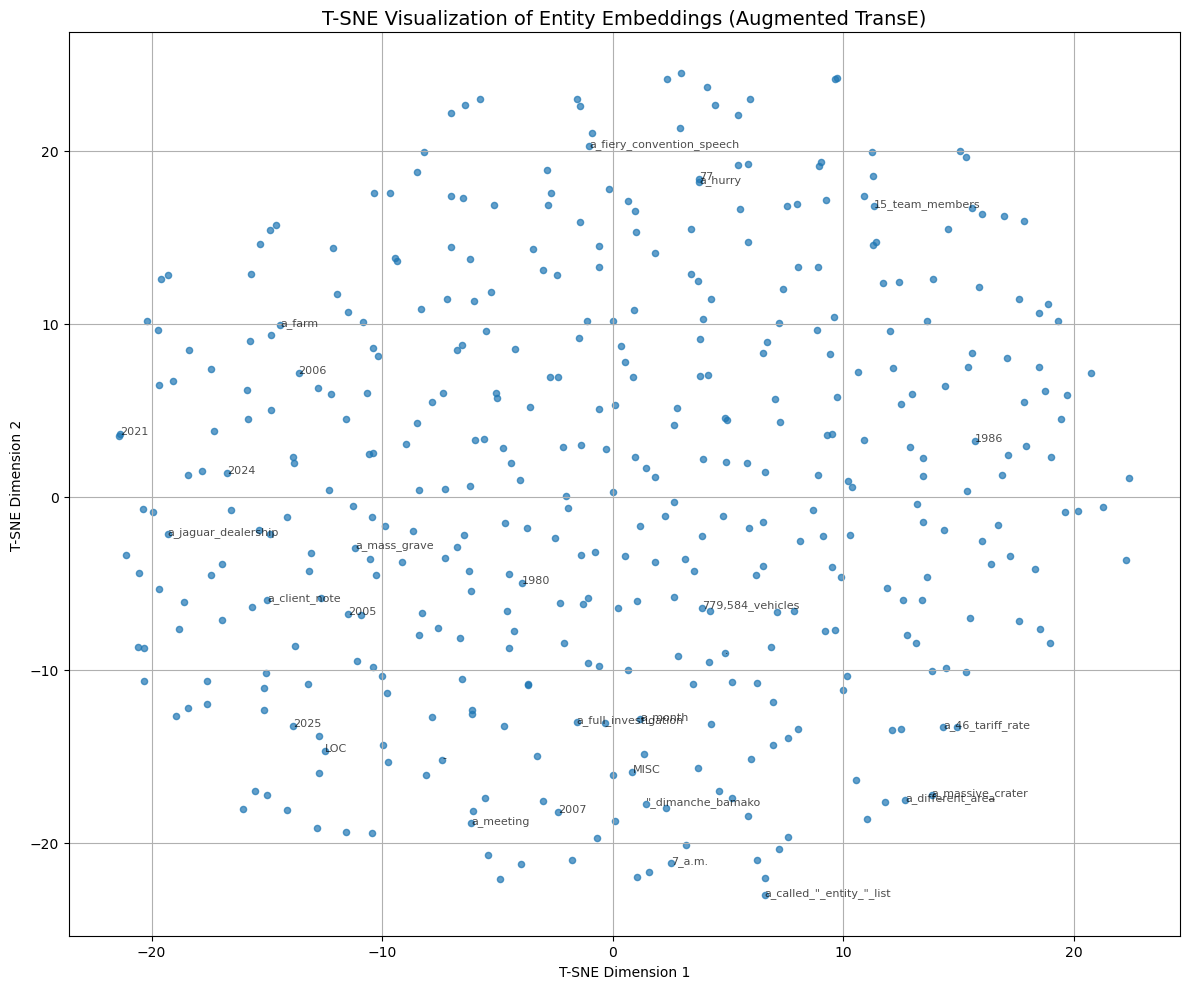

In [108]:
# Extract the trained entity embeddings from the model
entity_embeddings = results_aug.model.entity_representations[0]().cpu().detach().numpy()
entity_ids = list(results_aug.training.entity_id_to_label.values())

# Reduce the embeddings to 2D space using t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# Plot the 2D projection
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=20, alpha=0.7)

# Annotate a few entities for illustration (optional)
for i, label in enumerate(entity_ids[:30]):  # Display only the first 30 labels to avoid clutter
    plt.annotate(label.split('/')[-1], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title('T-SNE Visualization of Entity Embeddings (Augmented TransE)', fontsize=14)
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretation: 

Entities of the “year” type (2021, 2024, 2005, 1980) appear close to each other.

The model has potentially learned a notion of time or time series

In addition, entities such as client_note, jaguar_dealership and meeting are grouped together.

 This may indicate a potential semantic or situational proximity